# Day 2 handon exercise - QC and common bioinformatics scripting

Initially prepared for https://metabolomics-data.github.io/

By Shuzhao Li, 2019-07-07

In [1]:
# Import libaries
import os
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Designate input data
INDIR = "../data/"
datafile = "modc_ae_2012.txt"
datafile_ave = "ave_log2_modc_ae_2012.txt"

## About the data

These data are from Li et al. (2013) PLoS computational biology 9.7 (2013): e1003123, the mummichog paper. This was an experiment of infecting immune cells by yellow fever virus (YFV). Three experimental groups are baseline (0 hour), mock infection (6 hours of culture but no virus), and YFV infection (6 hours). Each group included three biological samples, and each biological sample was run as triplicates on a mass spectrometer coupled with liquid chromatography.

We have two data files here, one with all technical replicates ("modc_ae_2012.txt"), and the other with only biological samples, after averaging the technical replicates ("ave_log2_modc_ae_2012.txt").


In [2]:
# Get data and have a look
data = pd.read_csv(os.path.join(INDIR + datafile), sep="\t")
print(data.shape)
data.head()

(7995, 31)


,mz,time,mz.min,mz.max,p_0hr_01_1,p_0hr_01_3,p_0hr_01_5,p_0hr_02_1,p_0hr_02_3,p_0hr_02_5,...,mock_6hr_03_5,yf_6hr_01_1,yf_6hr_01_3,yf_6hr_01_5,yf_6hr_02_1,yf_6hr_02_3,yf_6hr_02_5,yf_6hr_03_1,yf_6hr_03_3,yf_6hr_03_5
0,85.02783,59.68820,85.02783,85.02783,15.5810,16.0425,15.3953,15.4143,15.7364,15.5532,...,17.5140,17.1734,16.9813,16.6582,16.8376,16.8148,17.2885,16.5967,16.4734,16.6048
1,85.04717,124.75120,85.04709,85.04739,14.4754,14.2709,14.3696,14.7142,14.8291,14.9959,...,16.6485,16.6961,16.3596,17.0661,15.2321,15.1615,16.5655,16.4316,16.1668,16.2193
2,85.06532,68.66651,85.06517,85.06547,14.4223,15.0515,15.1241,13.5224,16.7480,14.4095,...,9.7859,14.0113,15.8681,13.3699,9.9658,15.5703,16.5537,11.9470,10.3181,10.1656
3,85.10073,16.48022,85.10050,85.10078,14.5249,13.2573,13.5206,12.9044,11.4185,12.9223,...,13.3513,13.2977,13.1140,12.5569,12.9582,12.9960,13.0290,12.4184,13.0218,13.4085
4,86.05951,67.78485,86.05949,86.05980,10.6674,17.4235,17.4510,17.0197,17.0402,16.9958,...,18.5019,17.7391,17.9262,17.6089,17.5802,17.6529,17.7841,17.3077,10.7589,17.3895


In [3]:
# Quick look at the distribution
data.describe()

,mz,time,mz.min,mz.max,p_0hr_01_1,p_0hr_01_3,p_0hr_01_5,p_0hr_02_1,p_0hr_02_3,p_0hr_02_5,...,mock_6hr_03_5,yf_6hr_01_1,yf_6hr_01_3,yf_6hr_01_5,yf_6hr_02_1,yf_6hr_02_3,yf_6hr_02_5,yf_6hr_03_1,yf_6hr_03_3,yf_6hr_03_5
count,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,...,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000
mean,479.377606,165.949377,479.327571,479.427072,16.091406,16.144007,16.290922,16.295431,16.315426,16.322353,...,15.128743,15.094845,15.092034,15.099189,15.051516,15.031724,14.994553,14.868401,14.881003,14.868518
std,342.073061,176.799281,341.976838,342.167864,3.346315,3.014123,3.175106,3.097821,3.074942,3.036882,...,2.562970,2.598563,2.576173,2.579771,2.559279,2.564990,2.550496,2.546401,2.556360,2.558357
min,85.027830,7.669881,85.027830,85.027830,5.669500,6.686300,6.566200,5.196100,4.872700,6.010300,...,3.512400,3.712000,4.234400,3.804400,4.215300,3.854300,4.157900,4.361500,4.420400,2.779400
25%,188.985900,39.727415,188.985600,188.985950,13.991700,14.440850,14.322450,14.392750,14.341000,14.432600,...,13.714200,13.758000,13.748500,13.756350,13.765550,13.700750,13.748200,13.522450,13.555600,13.505700
50%,355.007800,65.112550,355.006600,355.007800,16.262200,16.319800,16.402300,16.310300,16.323600,16.331700,...,15.031400,15.012800,14.985800,15.023900,14.956500,14.956500,14.947000,14.801200,14.791400,14.813600
75%,744.717600,266.096100,744.692550,744.742500,18.549300,18.202250,18.568100,18.398400,18.433750,18.393900,...,16.636400,16.607300,16.594900,16.596100,16.557150,16.529100,16.447400,16.368850,16.394550,16.379800
max,1956.091000,581.636600,1956.005000,1956.201000,27.773700,27.874300,27.763600,27.549800,27.539900,27.600900,...,28.224400,25.859900,25.879600,25.871000,25.851200,25.828200,25.827900,25.649600,26.596200,26.576900


## Checking data distribution in samples

The data table above has the first four columns as parameters from the mass spectrometry experiment, and the intensity values start on the fifth column. Each column, starting on the fifth, has a label as from biological samples. The intensity values are already after log2 transformation and imputation.

We plot here the intensity distribution (histogram). The data after log transformation should approximate a normal distribution (this is why we do it). In the histogram below, there is a spike on the left, indicating many values close to 10. They were from imputation, i.e. missing values replaced by an arbitrary number, the common detection limit in the lab in this case.

Also meaningful but not covered here is the plot of number of missing values vs number of samples.

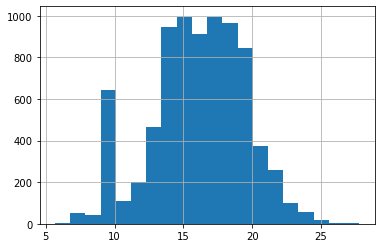

In [4]:
# Distribution of the intensity values in the first sample
data.iloc[:, 4].hist(bins=20)

## Quality control 

Bad data can be from bad samples, or malfunction of an instrument. 
We check data quality here by
* average ion intensity in each sample (same for toal intensity)
* correlation coefficient between technical replicates

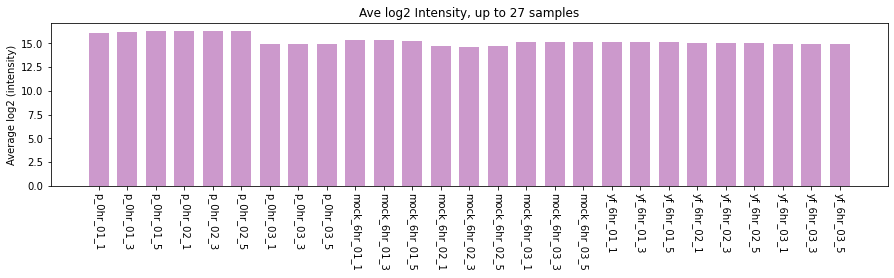

In [5]:
new_header = [x for x in data]

# if needed to transform to log2, shift positive 1 to avoid log2(0)
# new_data = np.log2(mydata[ new_header[4:] ] + 1)

new_data = data[new_header[4:]]

mean_TIC = new_data.mean(0)
# plot bars for first N columns, useful if large number of samples
N = 27
ind = np.arange(N)
plt.figure(figsize=(15,3))
plt.bar(ind, mean_TIC[:N], width=0.7, color="purple", alpha=0.4)
plt.ylabel("Average log2 (intensity)")
plt.title("Ave log2 Intensity, up to %d samples" %N)
plt.xticks(ind, new_data.columns[:N], rotation=-90)
plt.show()

# one should be alarmed if irregularity is spotted. Replicate of low intensity may be subject of removal.
# Alternatively, pandas dataframe has built-in plotting too (also via matplotlib)

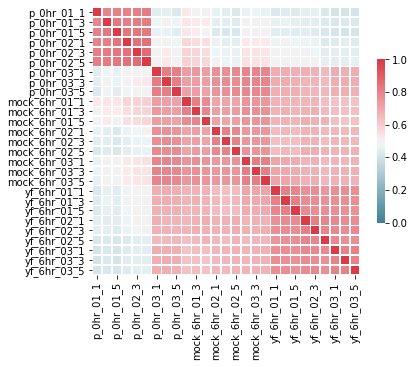

In [6]:
# Full heatmap of correlation coefficients
# default is Pearson correlation
full_corr = new_data.corr()
f, ax = plt.subplots(figsize=(6,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(full_corr, cmap=cmap, square=True, vmax=1, vmin=0,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

# Expecting high corr btw sample pairs

***From the quality control plots above, we conclude that each sample was measured with reasonable data.***

The intensity of the first two biologial samples (six replicates) is higher than others. These samples also form their own cluster in the correlation heatmap. We will discard these samples in our later analysis, focusing on the mock and yf samples only. But in general, the data needs to be normalized when the average (or total) signal intensity differs between samples.

### Plotting spike-in chemicals or landmark metabolites is also good QC

We use the example of phenylalanine here, which is consistently seen in human plasma using positive ESI on LC-MS. 

In [7]:
# look for phenylalanine, 165.079 + H
for ii in range(data.shape[0]):
    line = data.values[ii, :40]
    if abs(line[0]-(165.079 + 1.0073)) < 0.002: # this is about 10 ppm
        print (ii, line)

6462 [166.0853   55.88952 166.0852  166.0853   21.1867   20.9769   21.1796
  21.2868   22.7748   21.0402   22.4603   22.6261   22.4554   22.5407
  25.5013   23.234    22.6853   22.4184   22.7293   22.8745   23.0226
  25.1804   23.3842   23.5502   23.315    25.7823   23.6139   23.52
  23.3902   24.42     23.4337 ]


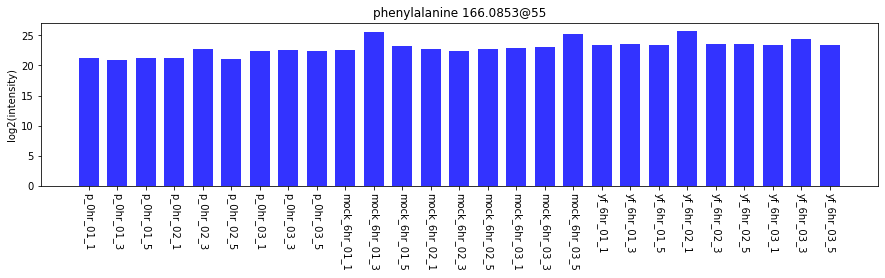

In [8]:
# plot line 6462 , matched to phenylalanine, 165.079 + H
N = 27
ind = np.arange(N)
plt.figure(figsize=(15,3))
plt.bar(ind, new_data.iloc[6462, :], width=0.7, color="blue", alpha=0.8)
plt.ylabel("log2(intensity)")
plt.title("phenylalanine 166.0853@55")
plt.xticks(ind, new_data.columns[:N], rotation=-90)
plt.show()

## Averaging technical replicates

If bad replicate or sample was spotted above, they should be removed from furhter processing.

We then take the average value of technical (injection) replicates, and use that as the value for one biological sample. 

For simplicity, this is not included in this notebook, but given in another notebook:
http://mummichog.org/notebooks/Averaging_technical_replicates.html

## We are switching to another data table from now on for all the code below

In [9]:
avedata = pd.read_csv(os.path.join(INDIR + datafile_ave), sep="\t")
print(avedata.shape)
avedata.head()

(7995, 11)


,mz,retention_time,mock_6hr_01,mock_6hr_02,mock_6hr_03,p_0hr_01,p_0hr_02,p_0hr_03,yf_6hr_01,yf_6hr_02,yf_6hr_03
0,85.02783,59,17.23,17.18,17.44,15.67,15.57,17.26,16.94,16.98,16.56
1,85.04717,124,16.53,15.80,16.62,14.37,14.85,15.63,16.71,15.65,16.27
2,85.06532,68,10.80,10.61,11.36,14.87,14.89,12.53,14.42,14.03,10.81
3,85.10073,16,13.32,13.16,13.42,13.77,12.42,13.31,12.99,12.99,12.95
4,86.05951,67,18.42,18.15,18.37,15.18,17.02,17.91,17.76,17.67,15.15


## Normalization


Normalization is to correct sample variations caused by technical factors, e.g. one sample started with more input materials in the measurement and causing higher values of most features.

There are methods popular in the field of transcriptomics, e.g. LOESS and quartile normalization, which can be used on metabolomics. However, when the data table contains many missing values, these normalization methods can be problematic. In general, if imputation (filling missing values) is needed, it should be done prior to normalization.

To safeguard against missing values in metabolomics, a simple approach is to scale each sample to the same mean intensity using only the most abundant features (e.g. 500 or 1000).

7995
(1000, 9)
[19.6097  18.71411 19.23487 20.06854 20.34723 18.85944 19.21792 19.02573
 18.81548]


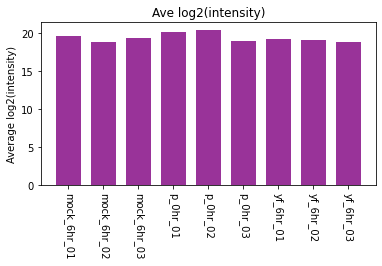

In [10]:
# plot the mean intensity of top 1000 features
m1 = list(avedata.iloc[:, 2:].mean(1))
print(len(m1))
new = []
for ii in range(len(m1)):
    new.append((m1[ii], list(avedata.iloc[ii,2:])))

new.sort(reverse=True)
new = np.array([x[1] for x in new[:1000]])
print(new.shape)
mean_TIC = new.mean(0)
print(mean_TIC)

N = 9
ind = np.arange(N)
plt.figure(figsize=(6,3))
plt.bar(ind, mean_TIC, width=0.7, color="purple", alpha=0.8)
plt.ylabel("Average log2(intensity)")
plt.title("Ave log2(intensity)")
plt.xticks(ind, avedata.columns[2:], rotation=-90)
plt.show()

In [11]:
# scale avedata by the mean of top 1000 features
scaling = [1, 1] + [mean_TIC[0]/x for x in mean_TIC]
print(scaling)

new_data = pd.DataFrame({})
#e.g. column 3 is avedata["mock_6hr_01"], first two columns are m/z and rtime
for ii in range(11):
    c = avedata.columns[ii]
    new_data[c] = avedata[c]*scaling[ii]

print(new_data.shape)
print(new_data.mean(0))
# the mean values are not expected to be the same but similar, because 
# we normalized the full list of 7995 features 
# using the scaling factor computed on the top 1000 features

[1, 1, 1.0, 1.0478564035372255, 1.0194870045911406, 0.9771363537158178, 0.9637528056644571, 1.039781669020924, 1.020386181230852, 1.0306936974297438, 1.0422109879737318]
(7995, 11)
mz                479.377606
retention_time    165.454034
mock_6hr_01        15.320818
mock_6hr_02        15.382946
mock_6hr_03        15.401406
p_0hr_01           15.805698
p_0hr_02           15.719941
p_0hr_03           15.506202
yf_6hr_01          15.403186
yf_6hr_02          15.487233
yf_6hr_03          15.500531
dtype: float64


## Group comparison using student's t-test

We will do a student's t-test between mock samples and YF samples.
Note that t-test assumes normal distribution of data, and our data are close to normal distribution by visual inspection at the beginning of this notebook. One can also test for the distribution.

If the distribution of data is not normal or not known, nonparametric methods (e.g. Wilcoxon rank sum test) can be used for group comparison. 

In [12]:
# in new_data, col 2:5 are mock, 8:11 are yf
number_features = new_data.shape[0]

t_scores, p_values, fc, fdrs = [], [], [], []
for ii in range(number_features):
    t,p = stats.ttest_ind(new_data.values[ii, 8:11], new_data.values[ii, 2:5])
    # nan may be returned
    if np.isnan(t):
        t,p = 0,1
    t_scores.append(t)
    p_values.append(p)
    # fold change, to used in volcano plot
    fc.append((new_data.values[ii, 8:11] - new_data.values[ii, 2:5]).mean())
        
print("t-test finished")

t-test finished


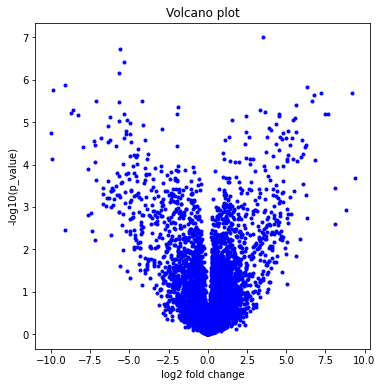

In [13]:
# Volcano plot to show the t-test result
plt.figure(figsize=(6,6))
plt.plot(fc, [-np.log10(ii) for ii in p_values], 'b.')
plt.xlabel("log2 fold change")
plt.ylabel("-log10(p_value)")
plt.title("Volcano plot")
plt.show()

In [14]:
# Compute FDR using Benjamini-Hochberg procedure
fdrs = multipletests(p_values, method = 'fdr_bh')[1]

#sort output, with full table
new = []
for ii in range(number_features):
    new.append([p_values[ii], fdrs[ii], t_scores[ii], 'row_'+str(ii+1)] + 
               list(new_data.values[ii, :]))

# it's always a good idea to assign a unique identifer for each feature as the first thing
# we add row number in the output, but it's better to use that from the start

new.sort()

# output full table
s = 'p-value\tFDR_BH\tt-score\trow_number\t' + '\t'.join(new_data.columns) + '\n'
for L in new:
    s += '\t'.join([str(x) for x in L]) + '\n'
    
with open('ttest_'+datafile_ave, 'w') as O:
    O.write(s)
    

In [15]:
# output row FDR < 0.05
fdr05_file = 'FDR.05' + datafile_ave
fdr05_list = [L for L in new if L[1]<0.05]
header = list(new_data.columns)
print(header)
s = 'p-value\tFDR_BH\tf-score\trow_number\t' + '\t'.join(header[:5] + header[8:]) + '\n'
for L in fdr05_list:
    # leaving out p_0hr samples
    s += '\t'.join([str(x) for x in L[:9] + L[12:]]) + '\n'
    
with open(fdr05_file, 'w') as O:
    O.write(s)
    

['mz', 'retention_time', 'mock_6hr_01', 'mock_6hr_02', 'mock_6hr_03', 'p_0hr_01', 'p_0hr_02', 'p_0hr_03', 'yf_6hr_01', 'yf_6hr_02', 'yf_6hr_03']


## Visualize the significant features using heatmap and boxplot

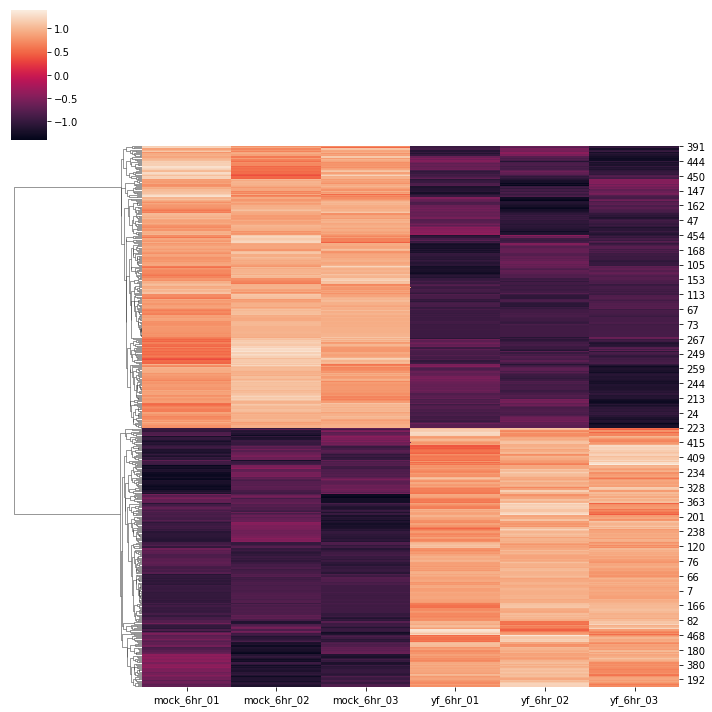

In [16]:
# to plot heatmap of features with FDR < 0.05

heatmap = pd.read_csv(fdr05_file, sep="\t")
g = sns.clustermap(heatmap.iloc[:, 6:12], col_cluster=False, z_score=0, figsize=(10, 10))


mock_6hr_01       9.06
mock_6hr_02    9.67171
mock_6hr_03    10.0419
yf_6hr_01      15.6221
yf_6hr_02      15.6872
yf_6hr_03      16.0292
Name: 72, dtype: object


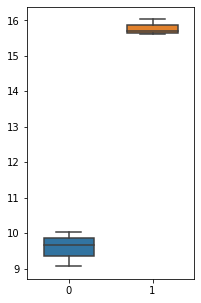

In [17]:
# to plot a feature at row # 73
box6 = heatmap.iloc[72, 6:12]

print(heatmap.iloc[72, 6:12])
# define groups
mock, infected = box6[:3], box6[3:]

# plotting
fig = plt.figure(figsize=(3, 5))
sns.boxplot(data=[mock, infected], width=0.6)

## Summary

This notebook was written to illustrate the several common scripting tasks.

To get basic Python training, readers are referred to the 6-hour course of programming in Python on the website of Software Carpentry (https://software-carpentry.org/lessons/).

The pandas library is the R equivalent in Python. Readers can read further on pandas (https://pandas.pydata.org/). 